This notebook loads the entire lexicon of words collected and creates a few visuals to help the viewer understand the content within the corpus.

#### Visuals Created:
* Word counts of top words
* Histogram of most frequently mentioned nouns
* Word plot of entire corpus

> Takeaway message: There are a number of significant words to be mindful of when discussing space. Now that we have this body of words involved, let's look deeper into understanding the way in which people understand these as it relates to sentiment, or opinion around them.

In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import logging
import multiprocessing

from time import time
from collections import defaultdict
from IPython.display import Image

from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples

/Users/tlipman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
df = pd.read_csv('final.csv')
df.shape

/Users/tlipman/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(549902, 8)

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,text,favorite_count,user_id,mentions,repost_count,post_id
0,0,0,earth order survive must stop global warming mar order survive need global warming,14116.0,UCmERzF_P0BZWGGjr2wGGnMQ,NaN,0.0,UgjwmZLS1tubQHgCoAEC
1,1,1,phase 4 moon declares independence tired earth tax,12898.0,UCRgqsjV2VMb11prjm_bIC8Q,NaN,0.0,UgxivzlZzuWNuRWrzCd4AaABAg
2,2,3,let get straight guy astronaut great public speaker also play guitar sing many lifetime doe normal person need accomplish,10670.0,UCwrM8uIAgp_QiA2VgdJeJRA,NaN,0.0,UgzXTACB0RAyXP1bs-Z4AaABAg
3,3,5,walk spider web australia thats called assisted suicide,9282.0,UC_m10vuJcLOosqYT5oOAKvg,NaN,0.0,Ughn5RK44AmdrngCoAEC
4,4,6,love video send existentialist crisis others make want build rocket backyard leave right,6820.0,UCcnv-fzEfAhmRyWC60HFSSg,NaN,0.0,Ugy3G3MZ7gCjCOxRSlF4AaABAg


In [5]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [6]:
df.head()

,text,favorite_count,user_id,mentions,repost_count,post_id
0,earth order survive must stop global warming mar order survive need global warming,14116.0,UCmERzF_P0BZWGGjr2wGGnMQ,NaN,0.0,UgjwmZLS1tubQHgCoAEC
1,phase 4 moon declares independence tired earth tax,12898.0,UCRgqsjV2VMb11prjm_bIC8Q,NaN,0.0,UgxivzlZzuWNuRWrzCd4AaABAg
2,let get straight guy astronaut great public speaker also play guitar sing many lifetime doe normal person need accomplish,10670.0,UCwrM8uIAgp_QiA2VgdJeJRA,NaN,0.0,UgzXTACB0RAyXP1bs-Z4AaABAg
3,walk spider web australia thats called assisted suicide,9282.0,UC_m10vuJcLOosqYT5oOAKvg,NaN,0.0,Ughn5RK44AmdrngCoAEC
4,love video send existentialist crisis others make want build rocket backyard leave right,6820.0,UCcnv-fzEfAhmRyWC60HFSSg,NaN,0.0,Ugy3G3MZ7gCjCOxRSlF4AaABAg


In [7]:
df.isnull().sum()

text                   0
favorite_count         0
user_id                2
mentions          219494
repost_count           0
post_id                0
dtype: int64

In [10]:
df_comments = df.drop(['favorite_count', 'user_id', 'mentions', 'repost_count', 'post_id'], axis=1)

In [11]:
df_comments.head()

,text
0,earth order survive must stop global warming mar order survive need global warming
1,phase 4 moon declares independence tired earth tax
2,let get straight guy astronaut great public speaker also play guitar sing many lifetime doe normal person need accomplish
3,walk spider web australia thats called assisted suicide
4,love video send existentialist crisis others make want build rocket backyard leave right


In [12]:
sent = [row.split() for row in df_comments['text']]

phrases = Phrases(sent) # Detect phrases based on collocation counts.

bigram = Phraser(phrases) # The goal of Phraser() is to cut down memory consumption of Phrases()

sentences = bigram[sent] # transform the corpus based upon bigrams detected

INFO - 23:24:29: collecting all words and their counts
INFO - 23:24:29: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 23:24:29: PROGRESS: at sentence #10000, processed 200978 words and 160468 word types
INFO - 23:24:29: PROGRESS: at sentence #20000, processed 416445 words and 296596 word types
INFO - 23:24:30: PROGRESS: at sentence #30000, processed 634263 words and 417432 word types
INFO - 23:24:30: PROGRESS: at sentence #40000, processed 850290 words and 532143 word types
INFO - 23:24:30: PROGRESS: at sentence #50000, processed 1058834 words and 628553 word types
INFO - 23:24:31: PROGRESS: at sentence #60000, processed 1267716 words and 719481 word types
INFO - 23:24:31: PROGRESS: at sentence #70000, processed 1463786 words and 809526 word types
INFO - 23:24:32: PROGRESS: at sentence #80000, processed 1653370 words and 887719 word types
INFO - 23:24:32: PROGRESS: at sentence #90000, processed 1882233 words and 976166 word types
INFO - 23:24:32: PROGRESS: at sent

In [13]:
model = Word2Vec()

t = time()

model.build_vocab(sentences)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 23:26:39: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2021-04-12T23:26:39.803824', 'gensim': '4.0.1', 'python': '3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]', 'platform': 'Darwin-19.6.0-x86_64-i386-64bit', 'event': 'created'}
INFO - 23:26:39: collecting all words and their counts
INFO - 23:26:39: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:26:40: PROGRESS: at sentence #10000, processed 181605 words, keeping 22936 word types
INFO - 23:26:40: PROGRESS: at sentence #20000, processed 376652 words, keeping 34046 word types
INFO - 23:26:40: PROGRESS: at sentence #30000, processed 574037 words, keeping 42409 word types
INFO - 23:26:41: PROGRESS: at sentence #40000, processed 769980 words, keeping 49490 word types
INFO - 23:26:41: PROGRESS: at sentence #50000, processed 957696 words, keeping 54846 word types
INFO - 23:26:41: PR

Time to build vocab: 0.26 mins


## EXPLORATORY DATA ANALYSIS

In [28]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/tlipman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tlipman/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [18]:
#most frequent and least frequent words 
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:20]
freq

space     107062
mar        79619
nasa       67312
would      43012
like       42940
wa         38483
spacex     37707
one        33798
earth      33484
moon       29518
time       29140
ha         28651
people     28428
get        27454
year       24171
know       23947
go         23305
think      23224
make       22174
dont       21944
dtype: int64

In [21]:
desc_str = ' '.join(df['text'].tolist())

In [22]:
tokens = nltk.word_tokenize(desc_str) #tokenizing 
print(len(tokens))

7347713


In [29]:
tokens_pos = nltk.pos_tag(tokens)
pos_df = pd.DataFrame(tokens_pos, columns = ('word','POS'))
pos_sum = pos_df.groupby('POS', as_index=False).count() # group by POS tags
pos_sum.sort_values(['word'], ascending=[False]) # in descending order of number of words per tag

,POS,word
12,NN,3377507
8,JJ,1426714
20,RB,433568
31,VBP,306608
3,CD,300477
29,VBG,289131
28,VBD,249758
27,VB,215184
15,NNS,191311
7,IN,153813


In [60]:
#the 100 most common nouns
filtered_pos = [ ]
for one in tokens_pos:
    if one[1] == 'NN' or one[1] == 'NNS' or one[1] == 'NNP' or one[1] == 'NNPS':
        filtered_pos.append(one)
print ("There are a total of", round(len(filtered_pos)/1000000, 4), "million nouns within the corpus.")
fdist_pos = nltk.FreqDist(filtered_pos)
top_100_words = fdist_pos.most_common(100)

There are a total of 3.5797 million nouns within the corpus.


In [40]:
top_words_df = pd.DataFrame(top_100_words, columns = ('pos','count'))
top_words_df['Word'] = top_words_df['pos'].apply(lambda x: x[0]) # split the tuple of POS
top_words_df = top_words_df.drop('pos', 1) # drop the previous column
top_words_df.head(20)

,count,Word
0,107062,space
1,63736,mar
2,29140,time
3,28428,people
4,24650,moon
5,24173,spacex
6,24171,year
7,23634,earth
8,22788,wa
9,21398,ha


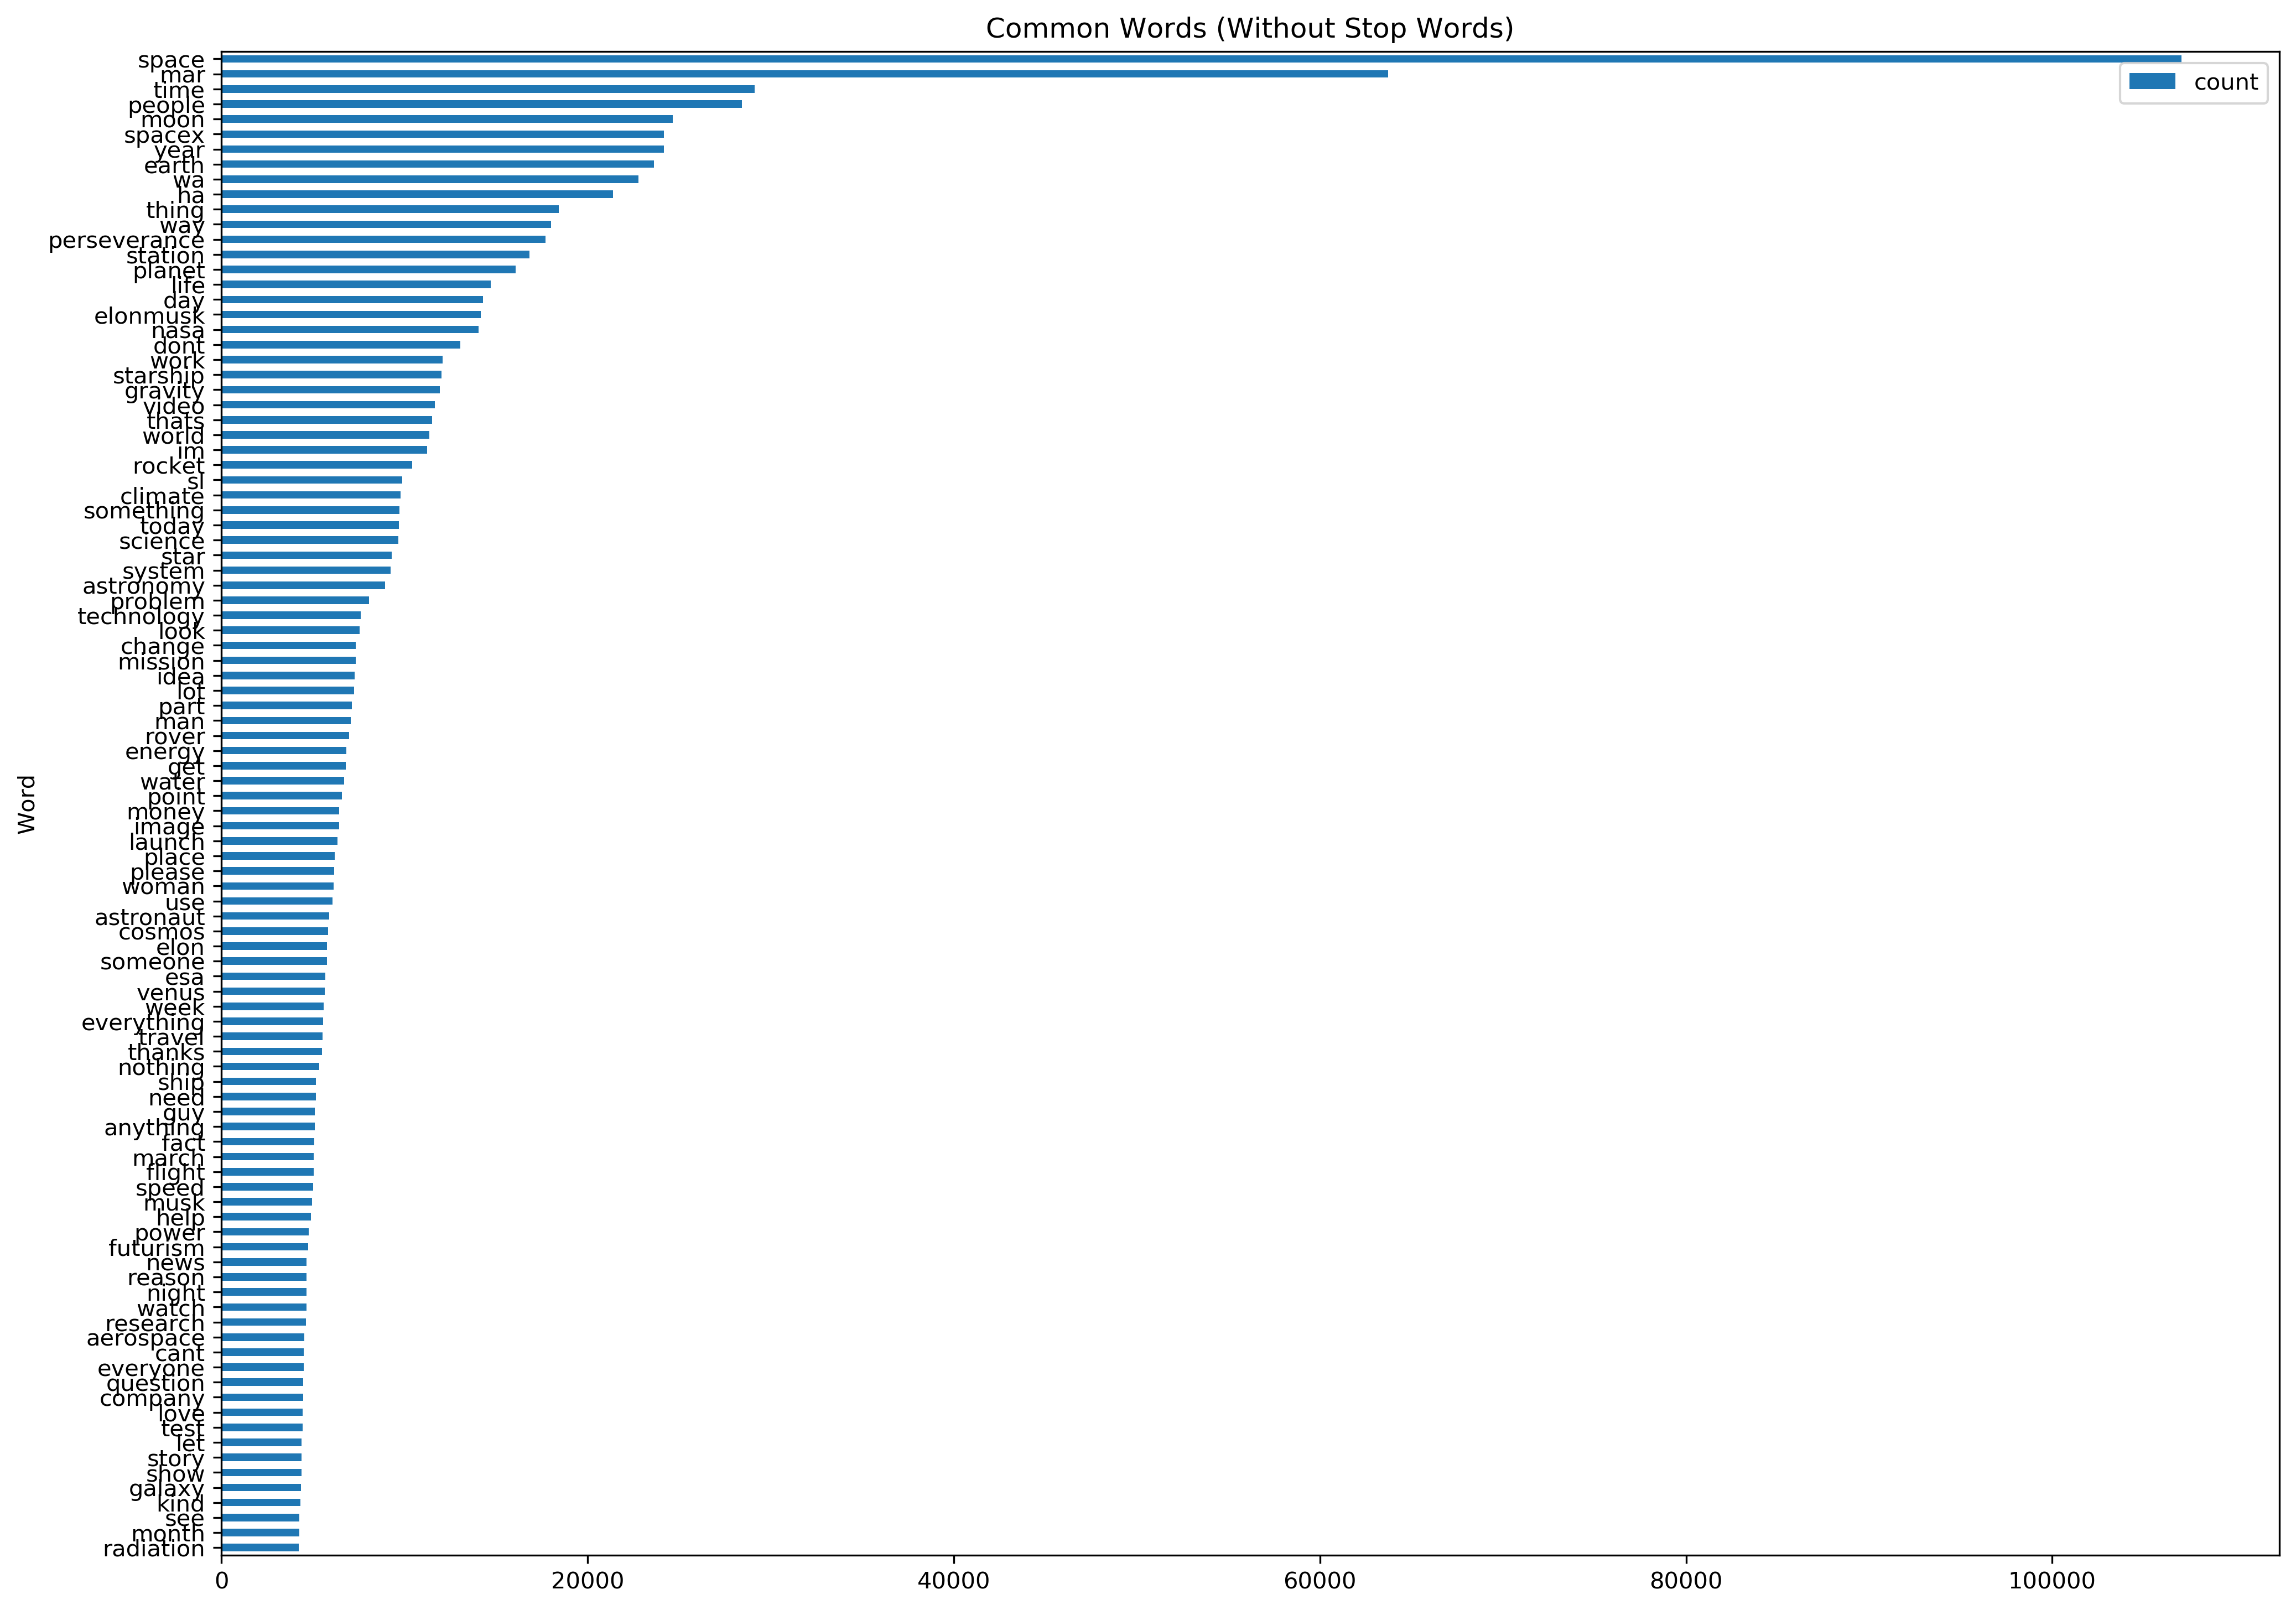

In [38]:
fig, ax = plt.subplots(figsize=(16,12), dpi=300)
top_words_df.sort_values(by='count').plot.barh(x='Word',
                      y='count',
                      ax=ax)

ax.set_title("Common Words (Without Stop Words)")

plt.show()

In [52]:
top_20 = top_words_df.head(20)

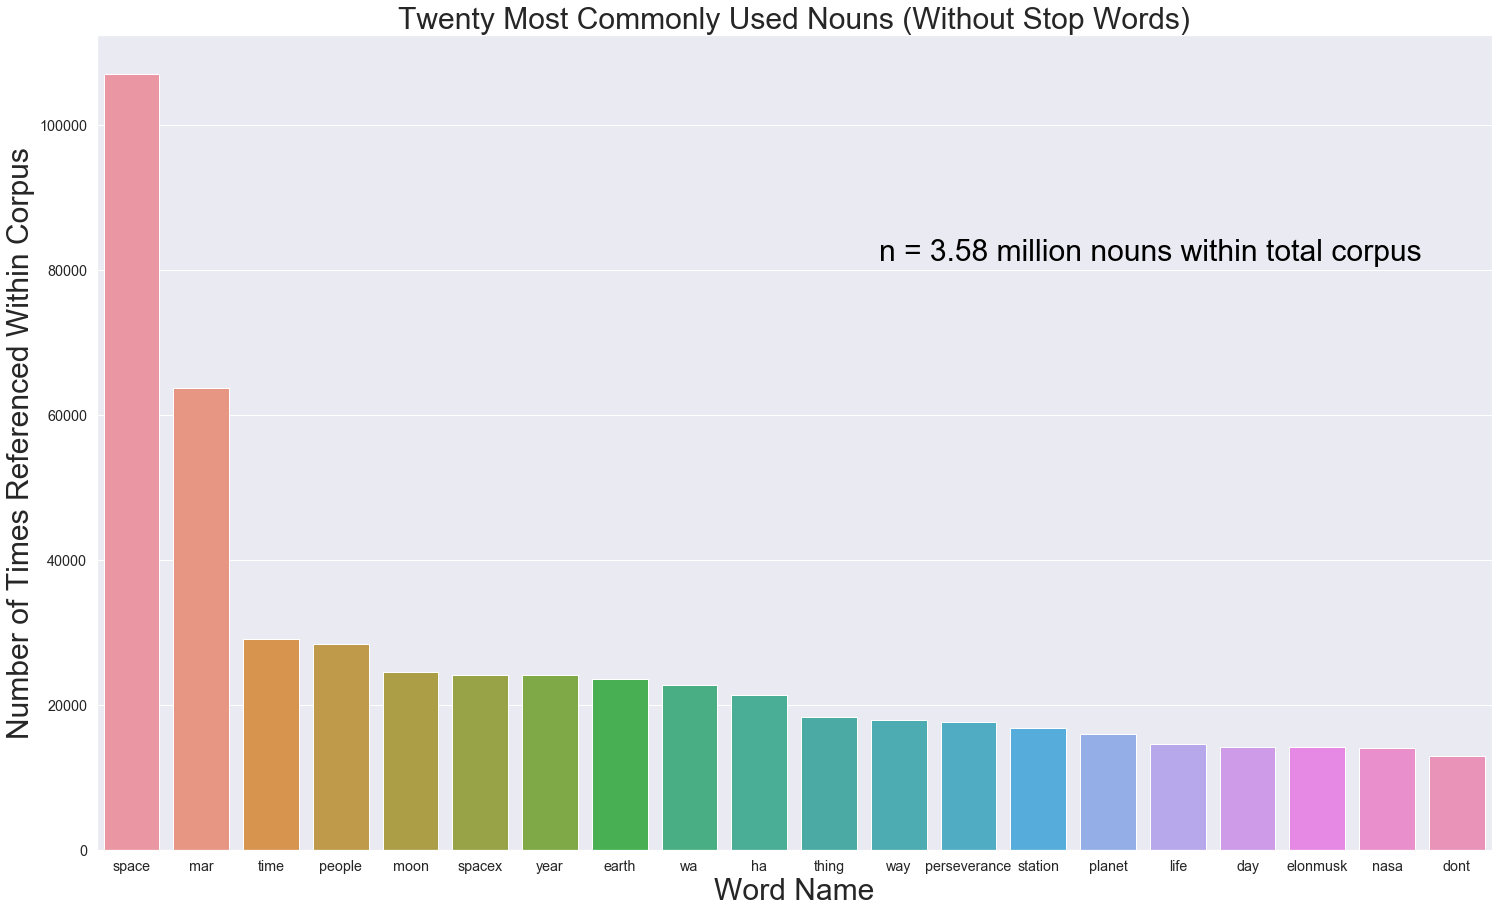

In [59]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.3)
pal = sns.color_palette("husl", 8)
ax = sns.barplot(x="Word", y="count",
                 data=top_20)
ax.set_title('Twenty Most Commonly Used Nouns (Without Stop Words)', fontsize=30)
ax.set_ylabel('Number of Times Referenced Within Corpus', fontsize=30)
ax.set_xlabel('Word Name', fontsize=30)
ax.text(.95, .75, 'n = 3.58 million nouns within total corpus',
        color='black', fontsize=30,
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes);

In [66]:
from wordcloud import WordCloud

In [67]:
word_counts = ' '.join(top_words_df['Word'].tolist())
print(type(word_counts))

<class 'str'>


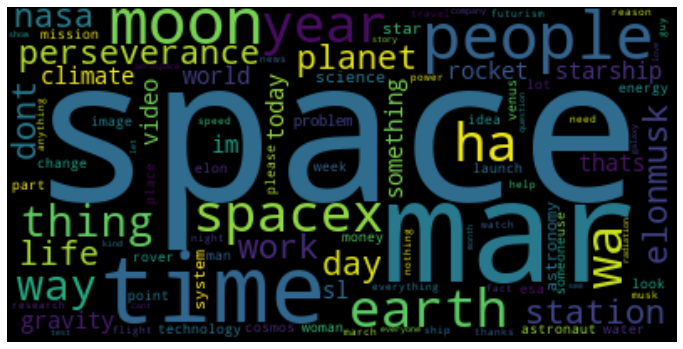

In [84]:
wordcloud = WordCloud().generate(word_counts)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
# creating a word frequency count for each individual word
# ensuring that lemmatization, removal of stop words, and bigrams reduced
# the total diversity of sentiment to be able to be more accurately measured and understood

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

380095

In [15]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['space', 'mar', 'nasa', 'would', 'wa', 'like', 'one', 'earth', 'time', 'get']

## Clustering

In [92]:
text = df_comments['text'] # establish the of text documents

vectorizer = TfidfVectorizer() # create the transform

X_tfidf = vectorizer.fit_transform(text)

In [86]:
x = df_comments.drop('text', 1)
y = vectorizer.fit_transform(df_comments['text'])

In [87]:
# displaying the multidimentionality of the dataset
y.shape

(549902, 351282)

In [93]:
kmeans = KMeans(n_clusters=10,
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

y_kmeans = kmeans.fit_predict(X_tfidf, df_comments['retweets'])

kmeans.inertia_

539320.4262618574

In [94]:
df_comments['cluster'] = y_kmeans

In [96]:
df_comments.head(40)

,text,cluster
0,earth order survive must stop global warming mar order survive need global warming,2
1,phase 4 moon declares independence tired earth tax,4
2,let get straight guy astronaut great public speaker also play guitar sing many lifetime doe normal person need accomplish,0
3,walk spider web australia thats called assisted suicide,0
4,love video send existentialist crisis others make want build rocket backyard leave right,0
5,man guy really know paint picture word,9
6,go mar people start flat mar society,2
7,danger entirely different fear coolest quote ever,0
8,build city moon imagine looking seeing crescent moon dark part lit light citites,4
9,else thought title meant went physically blind whilst space,3


### Visualizing the clusters

#### Elbow Method | Quantifying Distortion

In [59]:
distortions = []
ScoreList   = []
maxNumberOfClusters = 50

for i in range(1, maxNumberOfClusters):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X_tfidf)
    distortions.append(km.inertia_)
    ScoreList.append(-km.score(x_train))

AttributeError: module 'matplotlib' has no attribute 'plot'

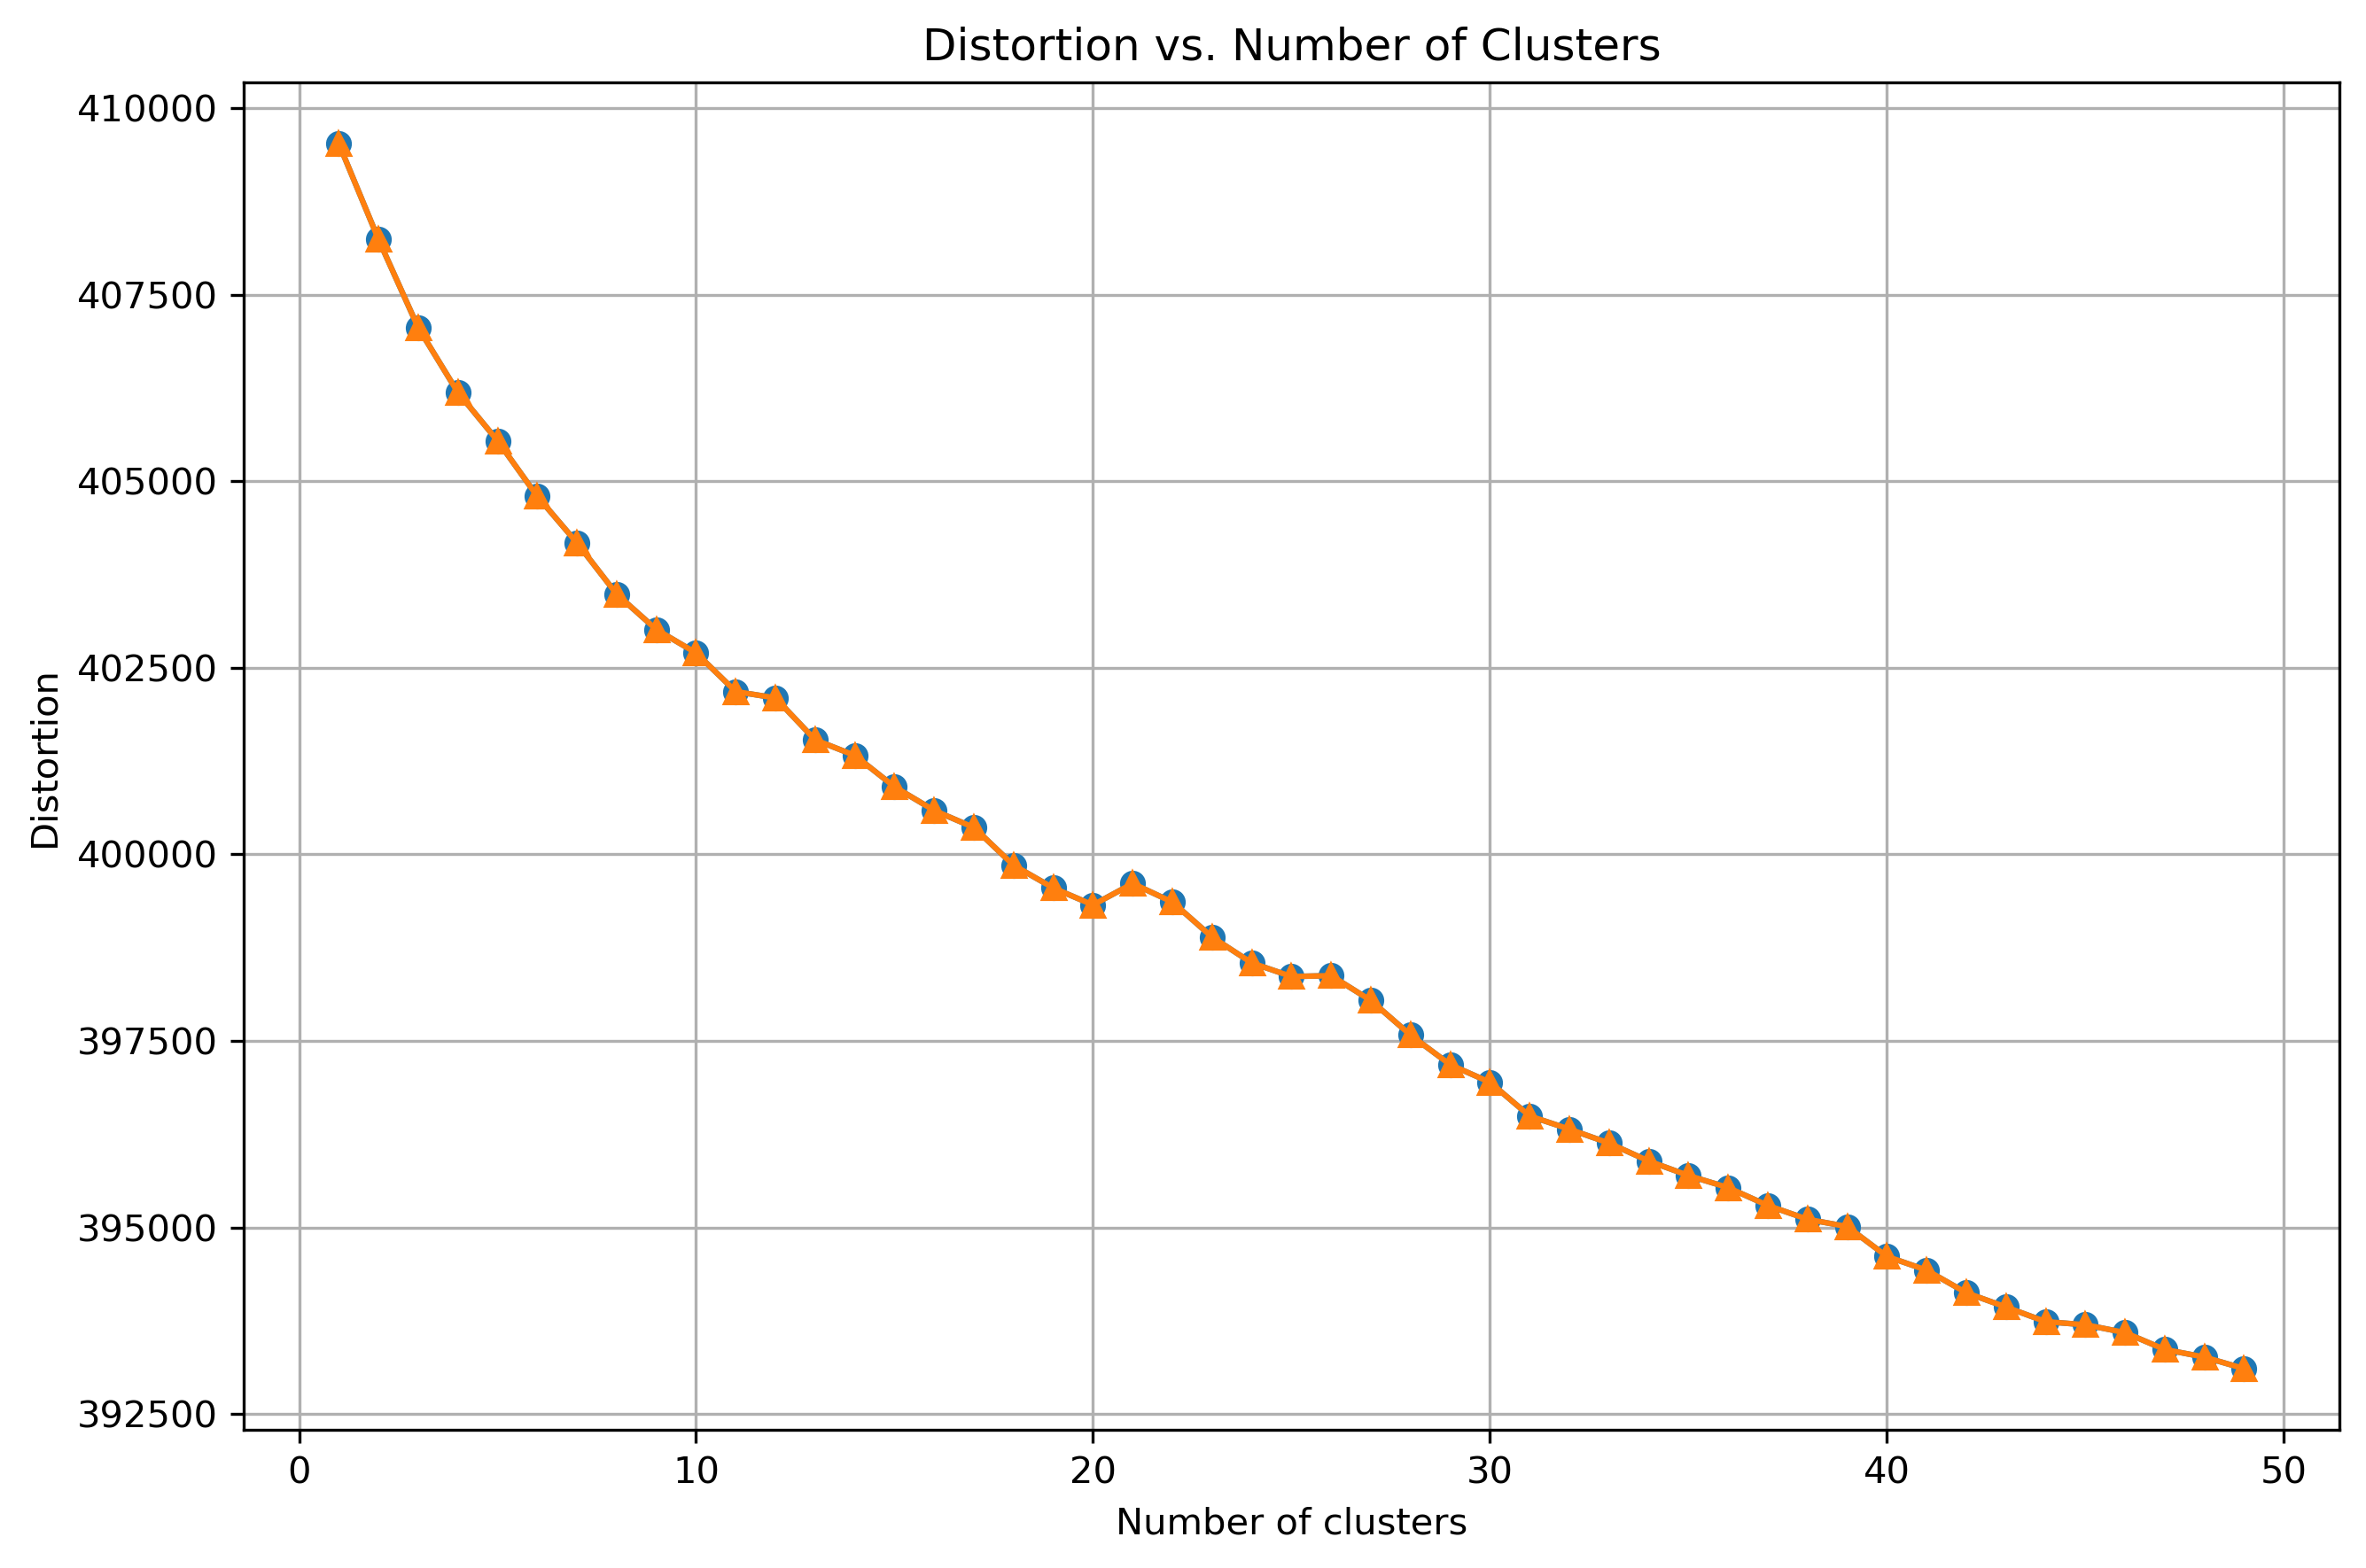

In [66]:
plt.figure(figsize=(9, 6), dpi=300)
plt.plot(range(1, maxNumberOfClusters), distortions, marker='o')
plt.plot(range(1, maxNumberOfClusters), ScoreList, marker='^')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion vs. Number of Clusters')
plt.tight_layout()
plt.grid(True)
#plt.savefig('images/11_03.png', dpi=300)
plt.show()